In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("dark")
sns.set_style("white")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from jcopml.plot import plot_actual_vs_prediction, plot_association_matrix, plot_residual

# import dataset

In [2]:
df = pd.read_feather("dataset/carUsedPriceFix.feather")

In [3]:
X = df.drop(columns="price").copy()
y = df["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((61268, 8), (15318, 8), (61268,), (15318,))

# pipeline

In [4]:
X_train.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
30718,C Class,2018,Semi-Auto,10798,Diesel,120.256183,55.166825,2.0
19353,Crossland X,2019,Manual,8971,Petrol,145.000000,44.800000,1.2
32951,Focus,2017,Manual,28001,Petrol,120.256183,55.166825,1.0
29920,C Class,2015,Manual,43927,Diesel,120.256183,55.166825,2.1
75671,Aygo,2017,Manual,31245,Petrol,145.000000,68.900000,1.0


In [5]:
num_pipe = make_pipeline(KNNImputer(n_neighbors=5), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocesor = make_column_transformer(
    (num_pipe, X_train.select_dtypes(include=["int64", "float64"]).columns),
    (cat_pipe, X_train.select_dtypes(include=["object"]).columns)
)

pipeline_model = make_pipeline(preprocesor, LinearRegression(n_jobs=-1, normalize=True))

# training

In [6]:
pipeline_model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('knnimputer', KNNImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    Index(['model', 'transmission', 'fuelType'], dtype='object'))])),
  ('linearregression', LinearRegression(n_jobs=-1, normalize=True))],
 'verbose':

In [7]:
params_tune = {
     'linearregression__normalize': [True, False]
}

model = RandomizedSearchCV(pipeline_model, params_tune, cv=3, n_iter=100, n_jobs=-1, verbose=3, random_state=42)
model.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('knnimputer',
                                                                                                KNNImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
     

In [8]:
model.best_params_

{'linearregression__normalize': False}

In [9]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8953969325320684, 0.8922710134533144)

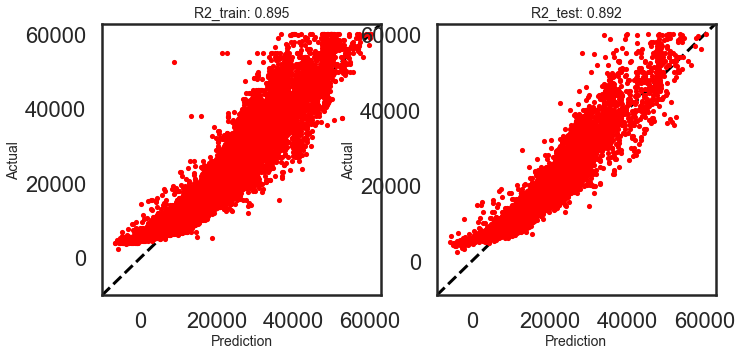

In [10]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

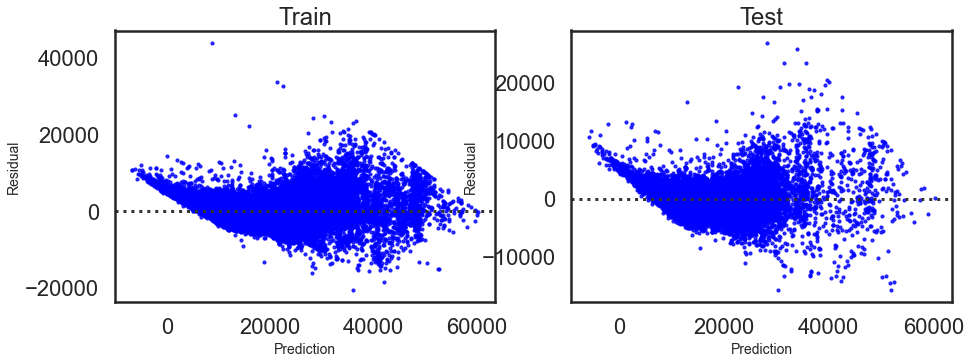

In [11]:
plot_residual(X_train, y_train, X_test, y_test, model, lowess=False)

# Random Forest Regression

In [12]:
num_pipe = make_pipeline(KNNImputer(n_neighbors=5), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocesor = make_column_transformer(
    (num_pipe, X_train.select_dtypes(include=["int64", "float64"]).columns),
    (cat_pipe, X_train.select_dtypes(include=["object"]).columns)
)

pipeline_model = make_pipeline(preprocesor, RandomForestRegressor(n_jobs=-1, verbose=3))

In [13]:
pipeline_model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('knnimputer', KNNImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    Index(['model', 'transmission', 'fuelType'], dtype='object'))])),
  ('randomforestregressor', RandomForestRegressor(n_jobs=-1, verbose=3))],
 'verb

In [14]:
params_tune = {
     'randomforestregressor__n_estimators': [38]
}

model_rf = RandomizedSearchCV(pipeline_model, params_tune, cv=3, n_iter=1, n_jobs=-1, verbose=3, random_state=42)
model_rf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 38
building tree 2 of 38
building tree 3 of 38
building tree 4 of 38
building tree 5 of 38
building tree 6 of 38
building tree 7 of 38
building tree 8 of 38
building tree 9 of 38
building tree 10 of 38
building tree 11 of 38
building tree 12 of 38
building tree 13 of 38
building tree 14 of 38
building tree 15 of 38
building tree 16 of 38
building tree 17 of 38
building tree 18 of 38
building tree 19 of 38
building tree 20 of 38
building tree 21 of 38
building tree 22 of 38
building tree 23 of 38
building tree 24 of 38


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.2s


building tree 25 of 38
building tree 26 of 38
building tree 27 of 38
building tree 28 of 38
building tree 29 of 38
building tree 30 of 38
building tree 31 of 38
building tree 32 of 38
building tree 33 of 38
building tree 34 of 38
building tree 35 of 38
building tree 36 of 38
building tree 37 of 38
building tree 38 of 38


[Parallel(n_jobs=-1)]: Done  36 out of  38 | elapsed:   29.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   29.8s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('knnimputer',
                                                                                                KNNImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
     

In [15]:
model_rf.score(X_train, y_train), model_rf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.0s finished


(0.9933307306853152, 0.9565836892881932)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.0s finished


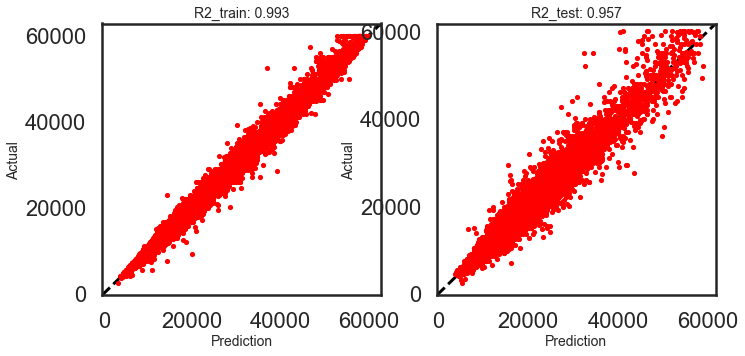

In [16]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_rf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.0s finished


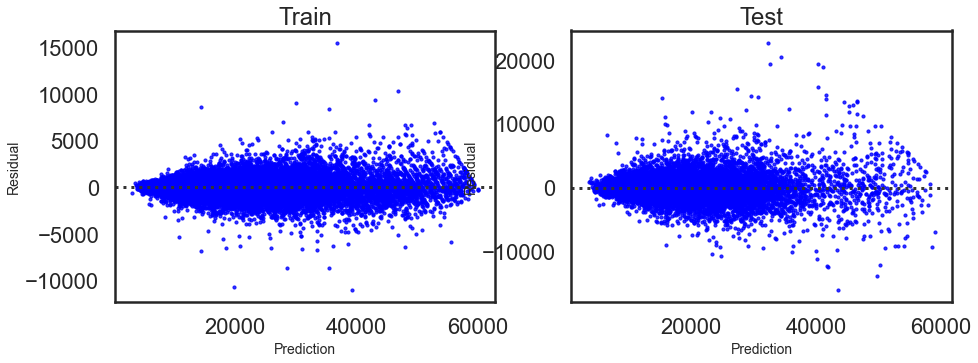

In [18]:
plot_residual(X_train, y_train, X_test, y_test, model_rf, lowess=False)

In [20]:
import pickle
#pickle.dump(model_rf, open("model/model_regresi_rf.pkl", 'wb'))

In [4]:
X_test

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
22600,X2,2019,Automatic,123,Petrol,145.000000,38.700000,2.0
1221,Q2,2018,Automatic,13144,Petrol,145.000000,54.300000,1.4
36847,Focus,2015,Manual,48153,Diesel,120.256183,55.166825,1.5
18427,Mokka X,2017,Manual,23428,Diesel,145.000000,68.900000,1.6
47148,Focus,2019,Manual,14151,Petrol,145.000000,46.300000,1.5
...,...,...,...,...,...,...,...,...
50831,I10,2014,Manual,42346,Petrol,104.000000,60.100000,1.0
35576,Focus,2018,Manual,8459,Petrol,120.256183,55.166825,1.5
71948,Touareg,2018,Semi-Auto,8478,Diesel,145.000000,34.500000,3.0
61290,C Class,2014,Automatic,41011,Petrol,150.000000,49.600000,2.0


In [5]:
data = [[
            str("honda"),
            int(2017),
            str("manual"),
            int(1000),
            str("bensin"),
            float(2500000),
            float(10.5),
            float(2.5)
        ]]
dataTest = pd.DataFrame(data, index=[0], columns=["model", "year", "transmission", "mileage", "fuelType", "tax", "mpg", "engineSize"])

In [6]:
dataTest

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,honda,2017,manual,1000,bensin,2500000.0,10.5,2.5


In [7]:
import pickle
model = pickle.load(open(r"C:\Users\ROG\Documents\used_car_regression\model\model_regresi_rf.pkl", 'rb'))

In [11]:
float(model.predict(dataTest)[0])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  36 out of  38 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:    0.0s finished


29583.763157894737